In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# General libraries
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf



import os
print(os.listdir(("/content/drive/MyDrive/Dataset/chest_xray")))

['.DS_Store', 'test', 'train', 'val']


In [ ]:
# input_path = '../input/chest_xray/chest_xray/'
input_path = '/content/drive/MyDrive/Dataset/chest_xray'

def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/Dataset/chest_xray/train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/Dataset/chest_xray/test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + '/test' + cond)):
            img = plt.imread('/content/drive/MyDrive/Dataset/chest_xray/test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [ ]:


# Hyperparameters
img_dims = 150
epochs = 15
batch_size = 32

# Getting the data
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)



Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)


#try

#optim=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
#model_3_hidden.compile(optimizer = optim, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer= optim, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_8 (Separabl (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_9 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization_4 (Batch (None, 75, 75, 32)       

In [ ]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
163/163 [==============================] - 2583s 16s/step - loss: 0.3651 - accuracy: 0.8198 - val_loss: 0.7257 - val_accuracy: 0.6283
Epoch 2/15
163/163 [==============================] - 81s 498ms/step - loss: 0.2910 - accuracy: 0.8794 - val_loss: 0.8018 - val_accuracy: 0.6201
Epoch 3/15
163/163 [==============================] - 81s 495ms/step - loss: 0.2610 - accuracy: 0.8900 - val_loss: 2.7490 - val_accuracy: 0.6250
Epoch 4/15
163/163 [==============================] - 81s 495ms/step - loss: 0.2556 - accuracy: 0.8898 - val_loss: 1.2817 - val_accuracy: 0.6234
Epoch 5/15
163/163 [==============================] - ETA: 0s - loss: 0.2243 - accuracy: 0.9132
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 81s 494ms/step - loss: 0.2243 - accuracy: 0.9132 - val_loss: 0.4457 - val_accuracy: 0.7829
Epoch 6/15
163/163 [==============

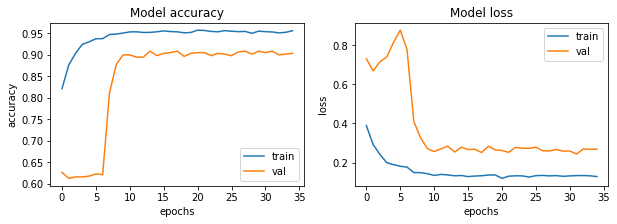

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

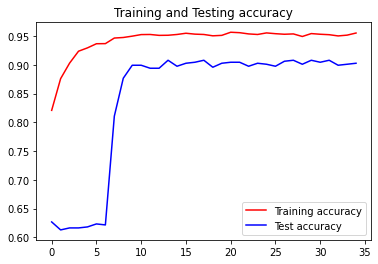

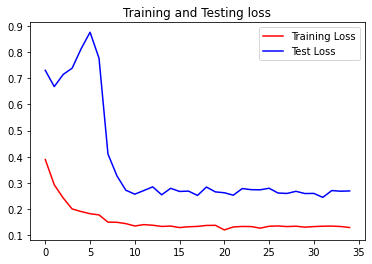

In [ ]:
acc3 = hist.history['accuracy']
val_acc3 = hist.history['val_accuracy']


loss3 = hist.history['loss']
val_loss3 = hist.history['val_loss']
epochs = range(len(acc3))

plt.plot(epochs, acc3, 'r', label='Training accuracy')
plt.plot(epochs, val_acc3, 'b', label='Test accuracy')
plt.title('Training and Testing accuracy')
plt.legend()
plt.show()




plt.plot(epochs, loss3, 'r', label='Training Loss')
plt.plot(epochs, val_loss3, 'b', label='Test Loss')
plt.title('Training and Testing loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[188  46]
 [ 12 378]]

TEST METRICS ----------------------
Accuracy: 90.7051282051282%
Precision: 89.15094339622641%
Recall: 96.92307692307692%
F1-score: 92.87469287469288

TRAIN METRIC ----------------------
Train acc: 95.54


In [ ]:
import numpy as np # linear algebra
#import pandas as pd 
import os
import cv2
from time import sleep
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, MaxPooling2D, Activation
from keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as k
import re
from glob import glob
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dropout,Dense,BatchNormalization,SpatialDropout2D
#from tqdm import tqdm_notebook as tqdm

In [ ]:
model=Sequential()

model.add(Conv2D(32,(3,3),padding='same',activation='relu',input_shape=(128,128,3)))
model.add(MaxPooling2D(2,2))
model.add(SpatialDropout2D(0.1))

model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.5))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(output_dim=128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(output_dim=128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(output_dim=1,activation='sigmoid'))

adam=keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

TypeError: ignored